### Предикт обученной моделью

In [436]:
#!g1.1
import numpy as np
import random
import os
import time
import pandas as pd
from tensorflow.keras.models import load_model
import cv2 as cv
import matplotlib.pyplot as plt 

In [437]:
#!g1.1
# Пути к данным
dataset_path = "/home/jupyter/work/resources/train/"
images_path = "/home/jupyter/work/resources/train/images"
anns_path = "/home/jupyter/work/resources/train/mask"
test_path = "/home/jupyter/work/resources/test" 
# Путь к сохраненным моделям
model_path = "/home/jupyter/work/resources/NIIAS-RZD/models" 
# Путь для сохранения результатов для лидербоарда
result_path = "/home/jupyter/work/resources/result"  

In [438]:
#!g1.1
# Создадим списки файлов с путями к ним
img_names= [ os.path.join(images_path, file_name) for file_name in os.listdir(images_path)]
ann_names = [ os.path.join(anns_path, file_name) for file_name in os.listdir(anns_path)]
test_names= [ os.path.join(test_path, file_name) for file_name in os.listdir(test_path)]

In [439]:
#!g1.1
# Классов сегментации
classes = [0, 6, 7, 10]
num_classes = len(classes)
print(num_classes)

4


In [440]:
#!g1.1
# Размеры изображения в модели
img_height = 432
img_width = 768
print(img_height, img_width)

432 768


#### Функции

In [441]:
#!g1.1
# Функция метрики, обрабатывающая пересечение двух областей 
# Кодировка OHE
def dice_coef(y_true, y_pred):
  # Возвращаем площадь пересечения деленную на площадь объединения двух областей
  return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.) 

In [442]:
#!g1.1
# Функция метрики, обрабатывающая пересечение двух областей d numpy
# Кодировка OHE
def dice_coef_np(y_true, y_pred):
  # Возвращаем площадь пересечения деленную на площадь объединения двух областей
  return (2. * np.sum(y_true * y_pred) + 1.) / (np.sum(y_true) + np.sum(y_pred) + 1.) 

In [443]:
#!g1.1
# Функция преобразования аннотации из ohe в классы
def ohe_to_mask(ann_ohe, classes=[0, 6, 7, 10]):
    
    ones = np.ones((ann_ohe.shape[0], ann_ohe.shape[1]),dtype = np.uint8)
    zeros = np.zeros((ann_ohe.shape[0], ann_ohe.shape[1]),dtype = np.uint8)
    
    result = zeros.copy()    
    
    result = np.where(ann_ohe[:,:,0] == 1, ones * 0, result)
    result = np.where(ann_ohe[:,:,1] == 1, ones * 6, result)
    result = np.where(ann_ohe[:,:,2] == 1, ones * 7, result)
    result = np.where(ann_ohe[:,:,3] == 1, ones * 10, result)
    
    return result    

In [444]:
#!g1.1
# Функция преобразования аннотации в one hot encoding
# classes = [0, 6, 7, 10]
def mask_to_ohe(ann_image, classes=[0, 6, 7, 10]):
    
    ones = np.ones((ann_image.shape[0], ann_image.shape[1], len(classes)),dtype = np.uint8)
    zeros = np.zeros((ann_image.shape[0], ann_image.shape[1], len(classes)),dtype = np.uint8)
    
    result = zeros.copy()
    
    result[:, :, 0] = np.where(ann_image == 0, ones[:, :, 0], zeros[:, :, 0])
    result[:, :, 1] = np.where(ann_image == 6, ones[:, :, 1], zeros[:, :, 1])
    result[:, :, 2] = np.where(ann_image == 7, ones[:, :, 2], zeros[:, :, 2])
    result[:, :, 3] = np.where(ann_image == 10, ones[:, :, 3], zeros[:, :, 3])
    
    return result

In [445]:
#!g1.1
# Функция автокоррекции контраста
def autocontrast(img):
    # converting to LAB color space
    lab= cv.cvtColor(img, cv.COLOR_BGR2LAB)
    l_channel, a, b = cv.split(lab)
    
    # Applying CLAHE to L-channel
    # feel free to try different values for the limit and grid size:
    clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l_channel)

    # merge the CLAHE enhanced L-channel with the a and b channel
    limg = cv.merge((cl,a,b))

    # Converting image from LAB Color model to BGR color spcae
    result = cv.cvtColor(limg, cv.COLOR_LAB2BGR)
    
    return(result)

In [446]:
#!g1.1
# Функция предикта
def pred_images(model, images_list):
    """
    :param model: путь к  модели для загрузки
    :param images_list: список изображений для обрабоки (можно подать и одиночную картинку)
    :return: mask_list или mask: список обработанных изображений или одну маску
    """
    # Список для возврата из функции
    mask_list = []
    
    # Чтобы обработать одиночную картинку
    if type(images_list) is not list:
        images_list = [images_list]
        mask_list = None

    for curr_image in images_list:
        # сохраним оригинальные размеры картинки
        curr_w = curr_image.shape[1]
        curr_h = curr_image.shape[0]
        
        # делаем предобработку (коррекцию контраста)
        curr_image = autocontrast(curr_image) 
        
        # переходим к RGB
        curr_image = cv.cvtColor(curr_image, cv.COLOR_BGR2RGB)
        
        # делаем ресайз к целевым размерам
        curr_image = cv.resize(curr_image, (img_width, img_height), interpolation=cv.INTER_AREA)
        
        # нормализуем
        curr_image = curr_image / 255.
        
        # добавляем ось
        curr_image = curr_image.reshape(1, img_height, img_width, 3)
#          img = np.expand_dims(img, axis = 0) 
        
        # получаем предикт
        predict = model.predict(curr_image)
        pred = predict[0]        
        pred = np.around(pred).astype(np.uint8)

        # пересчитываем его в маску
        mask = ohe_to_mask(pred)
        
        # ресайз маски к оригинальным размерам
        mask = cv.resize(mask, (curr_w, curr_h), interpolation=cv.INTER_NEAREST)
        
        if mask_list is not None:
            mask_list.append(mask)

    if mask_list == None:
        return mask
    else:
        return masks_list


#### Загружаем модель

In [447]:
#!g1.1
model_file = os.path.join(model_path, '05-Unet')
model = load_model(model_file, custom_objects={'dice_coef':dice_coef})

2022-07-21 10:40:48.884720: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-21 10:40:52.145398: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30995 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8c:00.0, compute capability: 7.0
/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:873: UserWarning: The following variables cannot be serialized: model
  warnings.warn(message)


#### Предикт нескольких картинок из train

2022-07-21 10:41:21.886172: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-07-21 10:41:24.423106: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8101


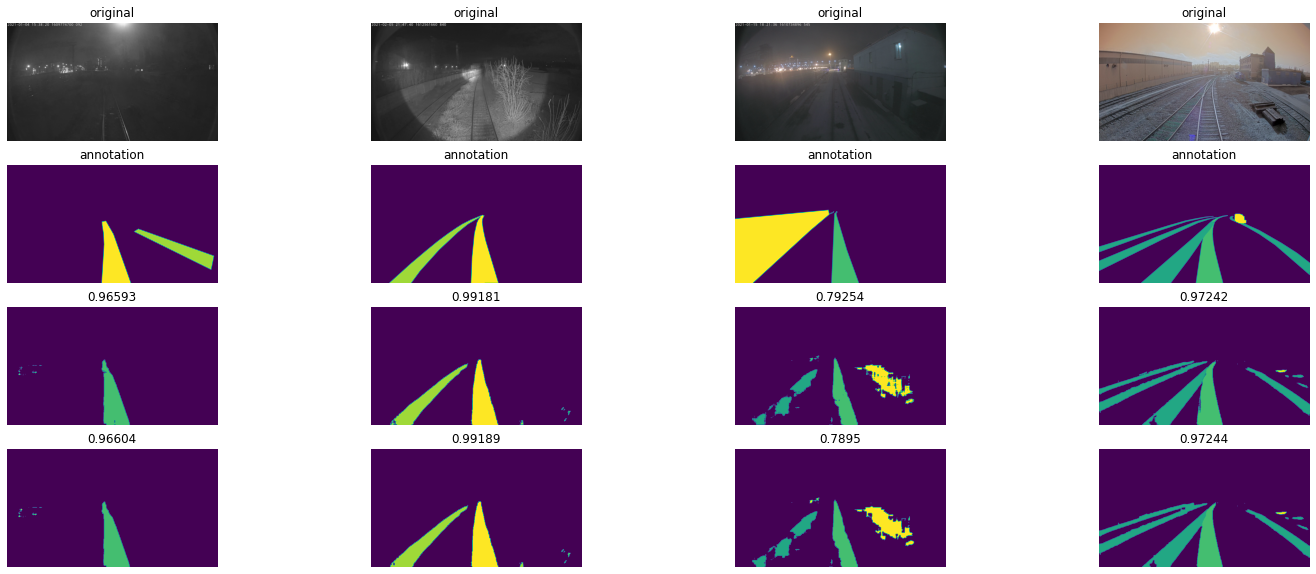

/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:873: UserWarning: The following variables cannot be serialized: model
  warnings.warn(message)


In [448]:
#!g1.1
# Предикт и визуализация картинок из train
n = 4
fig, axs = plt.subplots(4, n, figsize=(25, 10))  

n_files = random.choices(img_names, k=n) 

for i,file in enumerate(n_files):

    image = cv.imread(file)
    ann = cv.imread(os.path.join(anns_path, os.path.basename(file)), 0)
    pred= pred_images(model, image)
    
    # попробуем убрать шумы из маски
    kernel = np.ones((5, 5), 'uint8')
    pred_tuned = cv.dilate(pred, kernel, iterations=3)
    pred_tuned = cv.erode(pred_tuned, kernel, iterations=3)
    
#     print("ann:", ann.shape, np.unique(ann))
#     print("pred:", pred.shape, np.unique(pred))
#     print("pred_tuned:", pred_tuned.shape, np.unique(pred_tuned))
    

    axs[0,i].axis('off')
    axs[0,i].imshow(image)
    axs[0,i].set_title('original')

    axs[1,i].axis('off')
    axs[1,i].imshow(ann * 25)  
    axs[1,i].set_title('annotation')

    axs[2,i].axis('off')
    axs[2,i].imshow(pred * 25)
    axs[2,i].set_title(round(dice_coef_np(mask_to_ohe(ann), mask_to_ohe(pred)), 5))
    
    axs[3,i].axis('off')
    axs[3,i].imshow(pred_tuned * 25)
    axs[3,i].set_title(round(dice_coef_np(mask_to_ohe(ann), mask_to_ohe(pred_tuned)), 5))

plt.show()  

#### Предикт тестовых данных для лидербоарда

In [449]:
#!g1.1
# Предикт картинок из test
cur_time = time.time()
for idx,file in enumerate(test_names):
    image = cv.imread(file)
    pred = pred_images(model, image)
    
    # попробуем убрать шумы из маски
#     kernel = np.ones((5, 5), 'uint8')
#     pred = cv.dilate(pred, kernel, iterations=3)
#     pred = cv.erode(pred, kernel, iterations=3)
   
    file_name = os.path.join(result_path, os.path.basename(file))
    cv.imwrite(file_name, pred)
    
    # каждые 50 шагов 
    if idx % 50 == 0:
        print("Обработано {} из {} картинок".format(idx, len(test_names)))
    
    
print("Время выполнения: ", round(time.time() - cur_time, 2), 'c', sep='')

Обработано 0 из 1000 картинок
Обработано 50 из 1000 картинок
Обработано 100 из 1000 картинок
Обработано 150 из 1000 картинок
Обработано 200 из 1000 картинок
Обработано 250 из 1000 картинок
Обработано 300 из 1000 картинок
Обработано 350 из 1000 картинок
Обработано 400 из 1000 картинок
Обработано 450 из 1000 картинок
Обработано 500 из 1000 картинок
Обработано 550 из 1000 картинок
Обработано 600 из 1000 картинок
Обработано 650 из 1000 картинок
Обработано 700 из 1000 картинок
Обработано 750 из 1000 картинок
Обработано 800 из 1000 картинок
Обработано 850 из 1000 картинок
Обработано 900 из 1000 картинок
Обработано 950 из 1000 картинок
Время выполнения: 373.6c


/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:873: UserWarning: The following variables cannot be serialized: model
  warnings.warn(message)


In [463]:
#!g1.1
import zipfile
counter = 0
cur_time = time.time()
zf = zipfile.ZipFile("/home/jupyter/work/resources/NIIAS-RZD/results.zip", "w")
for dirname, subdirs, files in os.walk("/home/jupyter/work/resources/result"):
    for filename in files:
        if "img" in filename:
            zf.write(os.path.join(dirname, filename), filename, zipfile.ZIP_DEFLATED)
            counter +=1
zf.close()

print("Заархивировано файлов: ", counter)
print("Время выполнения: ", round(time.time() - cur_time, 2), 'c', sep='')

Заархивировано файлов:  1000
Время выполнения: 1.59c


In [ ]:
#!g1.1
